<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/6_NN_DeepLearning/Entrenamiento_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión lineal por gradiente descendiente

$$w^* = \arg \min_w J(w)=\|y-Xw\|^2_2$$

$$\nabla_w J(w) = \frac{2}{N}\left(X^\top\left(X w - y\right)\right) $$

$$w^t = w^{t-1} - \eta_t \nabla_w J(w)$$

NOTA: $\nabla_w J(w)$ se puede estimar con autodiff



theta_o: 
 [4 3]
theta_inv: 
 [[4.02496358]
 [2.96348022]]
theta_gd: 
 [[4.02496629]
 [2.96347497]]


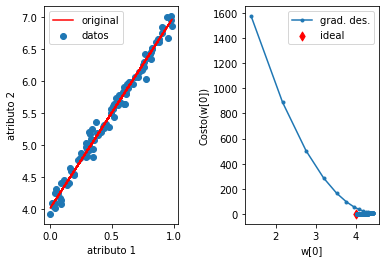

In [1]:
import numpy as np
import matplotlib.pyplot as plt

theta_o = np.array([4,3]) # parametros verdaderos
#simular datos
var = 0.01
np.random.seed(10)
X = np.random.rand(100, 1)
y = theta_o[0] + theta_o[1] * X + np.sqrt(var) *np.random.randn(100, 1)

X_b = np.c_[np.ones((100, 1)), X]  # añadir nivel dc modelo matricial
theta_inv = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) # solución analítica por inversa

theta_list = []
cost_list = []
eta = 0.1 #learning rate
n_epochs = 1000
theta = np.random.randn(2,1) # punto inicial de la solución
for iteration in range(n_epochs):
    gradients = (2/X_b.shape[0])*X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    theta_list.append(theta)
    cost_list.append(np.linalg.norm(y-X_b.dot(theta))**2)
print('theta_o: \n',theta_o)
print('theta_inv: \n',theta_inv)
print('theta_gd: \n',theta)
plt.subplot(121)
plt.scatter(X_b[:,1],y,label='datos')
plt.plot(X_b[:,1],X_b.dot(theta_o),label='original',c='r')
plt.xlabel('atributo 1')
plt.ylabel('atributo 2')
plt.legend()

plt.subplot(122)
plt.plot(np.array(theta_list)[:,0],np.array(cost_list),'.-',label='grad. des.')
plt.scatter(theta_o[0],0,marker='d',s=40,c='r',label='ideal')
plt.legend()
plt.xlabel('w[0]')
plt.ylabel('Costo(w[0])')
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.show()

# Gradiente descendiente por lote, por mini-lotes y estocástico

* El gradiente descendiente por lote (batch) utiliza TODAS las instancias disponibles para actualizar $\nabla_w J(w)$ en cada epoca.

* El gradiente descendiente por mini-lotes (mini-batch) utiliza UN SUBCONJUNTO aleatorio de muestras de tamaño fijo (batch-size) para actualizar $\nabla_w J(w)$.

* El gradiente descendiente estocástico utiliza UNA MUESTRA aleatoria para actualizar $\nabla_w J(w)$.

NOTA: Una epoca en grandiente por mini-lotes y gradiente estocástico corresponde al recorrido aleatorio de todo el conjunto de datos, es decir, el número total de iteraciones corresponderá a:

$$TotalIter= \#epochs \frac{N}{BatchSize}$$
 

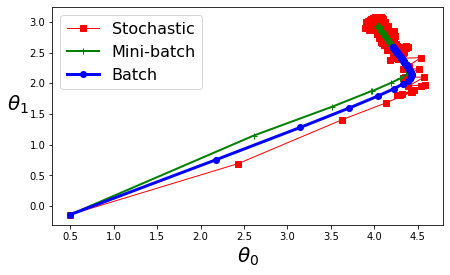

theta_s
 [[4.03577999]
 [2.98951515]]
theta_m
 [[4.03873909]
 [2.93560478]]
theta_b
 [[4.21344461]
 [2.59861593]]


In [2]:
np.random.seed(42) # fijar semilla para ejemplo ilustrativo

theta_path_bgd = []
theta_path_mgd = []
theta_path_sgd = []

n_epochs = 50 # número de epochs
batch_size = 32 # se sugiere colocar en 32,64,128,256
theta_s = np.random.randn(2,1)  # inicialización aleatoria - solución estocástico
theta_m = theta_s # solución mini lotes
theta_b = theta_s # solución por lote


theta_path_bgd.append(theta_b)
theta_path_mgd.append(theta_m)
theta_path_sgd.append(theta_s)

#decaimiento del learning rate para asegurar estabilidad cerca al mínimo 
# más iteraciones menos learning rate !
t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

# sgd
N = X_b.shape[0]
for epoch in range(n_epochs): #n epochs
    for i in range(N):  # recorrer datos
        random_index = np.random.randint(N)  # escoger muestra aleatoria
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta_s) - yi) #actualizar gradiente
        eta = learning_schedule(epoch * N + i) #actualizar learning rate
        theta_s = theta_s - eta * gradients #actualizar gradiente
        theta_path_sgd.append(theta_s)    

# mini_batch
t = 0
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(N) #reorganizar muestras de forma aleatoria para nueva epoch
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, N, batch_size): #recorrer datos por mini lotes
        t += 1 #conteo iteraciones totales
        xi = X_b_shuffled[i:i+batch_size]
        yi = y_shuffled[i:i+batch_size]
        gradients = 2/batch_size * xi.T.dot(xi.dot(theta_m) - yi)
        eta = learning_schedule(t)
        theta_m = theta_m - eta * gradients
        theta_path_mgd.append(theta_m)

#batch
for i in range(n_epochs):
    gradients = (2/X_b.shape[0])*X_b.T.dot(X_b.dot(theta_b) - y)
    theta_b = theta_b - eta * gradients
    theta_path_bgd.append(theta_b)  

#graficar convergencia en  2D
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)


plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.scatter(theta_o[0],theta_o[1],marker='d',s=100)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
#plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()
print('theta_s\n',theta_s)
print('theta_m\n',theta_m)
print('theta_b\n',theta_b)

Bajo un buen manejo del optimizador, las tres estrategias convergen a puntos parecidos

# Curvas de aprendizaje - sobreajuste y subajuste



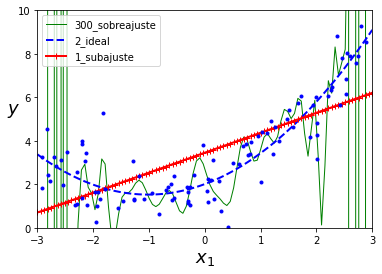

In [3]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


#datos de prueba
np.random.seed(40)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

#representación polinomial
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)

#regresor lineal sobre mapeo no lineal
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

y_new = lin_reg.predict(X_new_poly)



labels = ['_sobreajuste','_ideal','_subajuste']
ii = 0
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree)+labels[ii], linewidth=width)
    ii+=1

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])

plt.show()

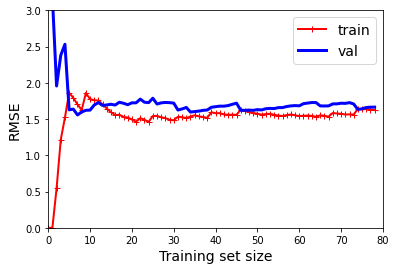

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

np.random.seed(40)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

#curvas de aprendizaje
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=30)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)  
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)             

lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         
plt.show()                                      

### **Modelo sub-entrenado** - más datos de entrenamiento no mejoran la generalización-se requiere un modelo más complejo o mejores características

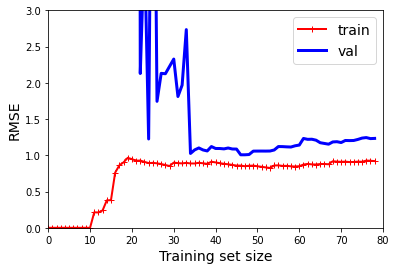

In [5]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])         
plt.show()                        

### **Modelo sobre entrenado** - se debe agregar más datos de entrenamiento para que el error de validación mejore o simplificar (regularizar) el modelo

### El balance entre sesgo y varianza

El error de generalización de un modelo puede ser expresado como la suma de tres errores diferentes:
#### Sesgo
Suposiciones erradas, ej: suponer datos lineales cuando en realidad son polinomiales. Un sesgo alto tiende a sub ajustar los datos de entrenamiento.

#### Varianza
Debido a la sensibilidad excesiva del modelo ante pequeñas variaciones en los datos de entrenamiento. Un modelo con muchos grados de libertad, tiende a generar alta varianza, y por  ende sobre entrenar los datos de entrenamiento.

#### Error irreducible
Debido al ruido de los datos. Solución: limpieza de datos, ajustar fuentes de captura, remover atípicos. 

Modelos más complejos incrementan la varianza y reducen el sesgo. Modelos más simples incrementan el sesgo pero reducen la varainza (se requiere de un balance).

# Inicializadores, normalización por lotes, optimizadores y regularizadores en Deep Learning

In [6]:
# Python ≥3.5 is required
import sys

# Scikit-Learn ≥0.20 is required
import sklearn

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



# Vanishing/Exploding Gradients Problem

# Desvanecimiento/no convergencia del gradiente

- En el backpropagation el gradiente de las capas iniciales no cambia (vanishing)

- En el backpropagation el gradiente se dispara

- En DL se generan gradientes inestables, diferentes capas aprenden a velocidades muy distintas!

- Posibles causas: incializacion tipo $\mathcal{N}(0,1)$ y activación logística, generan que las varianzas de las salidas de las capas sean más grandes que las varianzas de las entradas de las mismas. La sigmoide tiene problemas por saturación además del nivel dc 0.5

- Xavier Glorot y Yoshua Bengio demostraron dichas evidencias en 2010 [Paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?source=post_page---------------------------)

In [7]:
def logit(z): #funcion sigmoid
    return 1 / (1 + np.exp(-z))

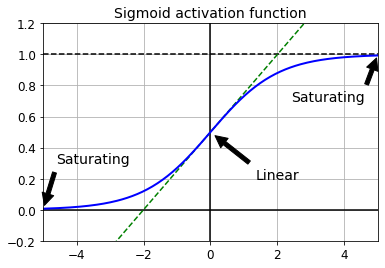

In [8]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## Inicializadores Xavier (Glorot) y He 

*   Se busca que la información fluya de forma estable en ambas direcciones: forward y backward
*   No la información no deberia ni morir (vanishing) ni explotar o saturarse.

* Clave: la varianza de las salidas de las capas se iguala a la varianza de las entradas de las capas. Además, se espera que el gradiente fluya con igual varianza antes y después de fluir por una capa.

* Dado que no es posible mantenar las claves anteriores por la variabilidad en el número de neuronas y entradas en una capa (fan-in fan-out de la capa), Glorot y Bengio proponen un modelo que mantiene un buen compromiso (inicialmente definido para activaciones sigmoid):

$$ w_0 \sim \mathcal{N}\left(0,1/fan_{avg}\right)$$ 
o
$$ w_0 \sim \mathcal{U}\left(-\sqrt{3/fan_{avg}},+\sqrt{3/fan_{avg}}\right)$$ 

donde $fan_{avg}= (fan_{in}+fan_{out})/2$

* Cuando $fan_{avg}=fan_{in}$ se obtiene el inicializador de Yann LeCun, o LeCun initialization (1990).

* Glorot puede mejorar el rendimiento y la velocidad de entrenamiento considerablemente!

Algunas otras alternativas de inicializadores se basan en las ideas de LeCun y Glorot modificando el uso de $fan_{avg}$ y $fan_{in}$ y el tipo de activación:


|Inicializador|Función de activación| $\sigma^2$ (Normal)|
|---|---|---|
|Glorot| linear, tanh, logist,softmax| 1/$fan_{avg}$|
|He| ReLU y variantes| 2/$fan_{in}$|
|LeCun| SELU| 1/$fan_{in}$|




In [9]:
#keras initializers
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [10]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [11]:
# se escala la variance o rango sobre el que se quiere muestrear
#https://www.tensorflow.org/api_docs/python/tf/keras/initializers/VarianceScaling
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

# Funciones de activación sin saturación
## Nonsaturating Activation Functions

* Aunque la activación en neuronas biológicas se asemejan a la función sigmoide, la saturación es un problema en el entrenamiento de la red (vanishing/exploding)

* Alternativa: ReLU -> simple de implementar y no saturada

* Problema de ReLU: dying ReLU, algunas neuronas marcan cero a la salida por el modelo de la $ReLU(x) = \max(0,x)$.

* El problema del dying ReLU es muy evidente para learning rates grandes, dado que el gradiente es cero para salidas negativas sobre la ReLU, las neuronas seguiran generando ceros!.

 

### Leaky ReLU

$Leaky ReLU(x) = \max(\alpha x,x)$

Algunas variantes de ReLU, buscando jugar con el factor de escala $\alpha$ para inducir un "coma" en las neuronas, del cual puedan volver en algún punto del entrenamiento se pueden encontrar en el siguiente [Paper](https://arxiv.org/abs/1505.00853) 2015

In [12]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

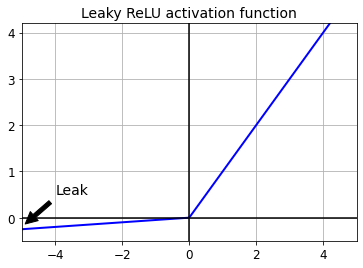

In [13]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [14]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [15]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Pruebas sobre Fashion MNIST en Leaky ReLU:

In [16]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [17]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 3ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7158
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5832 - accuracy: 0.8075 - val_loss: 0.5582 - val_accuracy: 0.8202
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5338 - accuracy: 0.8224 - val_loss: 0.5157 - val_accuracy:

Ahora con PReLU (parámetro $\alpha$ se aprende en el entrenamiento):

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [21]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [22]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7628
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6966 - accuracy: 0.7693 - val_loss: 0.6565 - val_accuracy: 0.7882
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5917 - accuracy: 0.8056 - val_loss: 0.5656 - val_accuracy: 0.8180
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5619 - accuracy: 0.8134 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5390 - accuracy: 0.8205 - val_loss: 0.5196 - val_accuracy:

### ELU

In [23]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

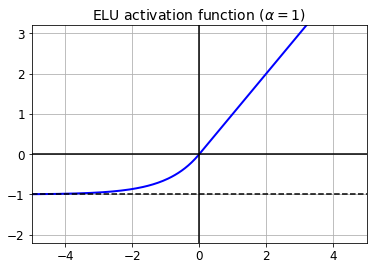

In [24]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()


$
ELU_\alpha(x) = \left\{\begin{split} \alpha(\exp(x)-1)& \quad if \quad & x < 0 \\
x & \quad if \quad & x \geq 0 \\
\end{split}\right. 
$


In [25]:
keras.layers.Dense(10, activation="elu")

### SELU

* Esta función de activación se propusó en 2017 [Paper](https://arxiv.org/pdf/1706.02515.pdf) por Günter Klambauer, Thomas Unterthiner y Andreas Mayr. 

* Garantiza una auto-normalización para modelos secuenciales.


$
SELU_\alpha(x) = \lambda\left\{\begin{split} \alpha(\exp(x)-1)& \quad if \quad & x < 0 \\
x & \quad if \quad & x \geq 0 \\
\end{split}\right. 
$


In [26]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [27]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

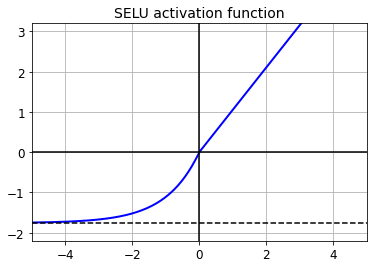

In [28]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

* En general, los hiperparámetros de SELU ($\lambda$ y $\alpha$) se ajustan de tal forma que la salida promedio de cada neurona este cercana a 0, y la desviación estandard cercana a 1 (asumiendo que las entradas se estandarizan de igual  manera). 

* Para modelos profundos y densos se evita los problemas de vanishing/exploding

In [29]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Utilizando SELU en  modelos densos:

In [30]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Probando en Fashion MNIST:

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Antes de entrenar recuerde normalizar las entradas a media 0 y std 1:

In [34]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [35]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 33s 18ms/step - loss: 1.1878 - accuracy: 0.5528 - val_loss: 0.9389 - val_accuracy: 0.6238
Epoch 2/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.7896 - accuracy: 0.7087 - val_loss: 0.6479 - val_accuracy: 0.7638
Epoch 3/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.6458 - accuracy: 0.7609 - val_loss: 0.6987 - val_accuracy: 0.7376
Epoch 4/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.5817 - accuracy: 0.7853 - val_loss: 0.5515 - val_accuracy: 0.7998
Epoch 5/5
1719/1719 [==============================] - 28s 17ms/step - loss: 0.5698 - accuracy: 0.7944 - val_loss: 0.5163 - val_accuracy: 0.8156


Si se prueba ReLU en vez de SELU:

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

In [37]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [39]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 33s 17ms/step - loss: 1.7842 - accuracy: 0.2647 - val_loss: 1.3731 - val_accuracy: 0.4124
Epoch 2/5
1719/1719 [==============================] - 29s 17ms/step - loss: 1.2071 - accuracy: 0.4883 - val_loss: 0.9528 - val_accuracy: 0.6290
Epoch 3/5
1719/1719 [==============================] - 28s 16ms/step - loss: 0.9518 - accuracy: 0.6199 - val_loss: 0.8759 - val_accuracy: 0.6388
Epoch 4/5
1719/1719 [==============================] - 28s 16ms/step - loss: 0.8794 - accuracy: 0.6545 - val_loss: 0.7323 - val_accuracy: 0.7220
Epoch 5/5
1719/1719 [==============================] - 28s 16ms/step - loss: 0.7443 - accuracy: 0.7182 - val_loss: 0.6689 - val_accuracy: 0.7504


No tan buen resultado, problemas de vanishing/exploding.

## Sugerencias:

* En general, el ranking de rendimiento es el seguiente: SELU>ELU>leakyReLU>ReLU>tanh>sigmoid.

* Si la red esta auto-normalizadas, la ELU puede rendir más que SELU (SELU no es suave en $x=0$).

* Si se requiere buena velocidad de cómputo se sugiere LeakyReLU.

* ReLU es la más utilizada por su buen compromiso, muchos aceleradore de cómputo están optimizados para trabajar con esta activación.

# Normalización por lote
## Batch Normalization - BN

* Aunque un buen inicializador y una buena función de activación previenen los problemas de vanishing/exploding, al inicio del entrenamiento, durante las iteraciones el vanishing/exploding puede volver!.

* En el 2015 [Paper](https://arxiv.org/abs/1502.03167), se propone la técnica Batch Normalization, que consiste en añadir una operación antes y después de cada capa.

* La normalización consiste de dos operaciones: escalamiento y traslación (dos nuevos parámetros por aprender en cada capa).

* Si la capa BN se añade como primera capa, entonces no es necesario escalar los datos de entrada.

* BN evalua la media y std de la entrada a la capa sobre el mini-batch (mini-lote) actual, con base en:


$\mathbf{\mu}_B = \frac{1}{N_B}\sum_{i=1}^{N_B} \mathbf{x}^{(i)}$

$\mathbf{\sigma}_B^2 = \frac{1}{N_B}\sum_{i=1}^{N_B} (\mathbf{x}^{(i)}-\mathbf{\mu}_B)^2$

$\hat{\mathbf{x}}^{(i)}= \frac{\mathbf{x}^{(i)}-\mathbf{\mu}_B}{\sqrt{\mathbf{\sigma}_B^2+\epsilon}}$

$\mathbf{z}^{(i)}=\mathbf{\gamma}\otimes \hat{\mathbf{x}}^{(i)}+\mathbf{\beta}$

* BN estandariza y luego reescala.

* Para datos nuevos se utliza promediado movil durante el entrenamiento.

* En resumen se estiman cuatro parámetros: $\gamma$ (escala), $\beta$ (traslación) se aprenden por backpropagation, y $\mu$ (media  final de entrada) y $\sigma$ (desviación final de entrada) por promediado móvil.

* NOTA: $\mu$ y $\sigma$ se estiman en entrenamiento pero solo se usen después de entrenar para evaluar datos nuevos.

* BN ha mostrado grandes resultados en procesado de imágenes, por ejemplo en ImageNet.

* El problema de vanishing se reduce e incluso permite utlizar activaciones saturadas como tanh  y sigmoid con BN.

* Además, BN es menos sensible a la inicialización de los pesos y  permite usar learning rates más grandes.

* BN se puede entender también como un regularizador al escalar y trasladar el flujo de información en la red.

* Problema: BN incluye más costo y operaciones en el entrenamiento y evaluación de la red.





In [40]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [41]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [42]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables] #parámetros entrenables y no entrenables en BN

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [43]:
bn1.updates #operaciones definidas en keras para promediado movil

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


[]

In [44]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [45]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.8750 - accuracy: 0.7123 - val_loss: 0.5525 - val_accuracy: 0.8230
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5754 - accuracy: 0.8031 - val_loss: 0.4724 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5189 - accuracy: 0.8204 - val_loss: 0.4373 - val_accuracy: 0.8546
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4827 - accuracy: 0.8325 - val_loss: 0.4151 - val_accuracy: 0.8602
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4566 - accuracy: 0.8406 - val_loss: 0.3998 - val_accuracy: 0.8642
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4397 - accuracy: 0.8475 - val_loss: 0.3868 - val_accuracy: 0.8698
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4242 - accuracy: 0.8513 - val_loss: 0.3763 - val_accuracy:

* En algunos casos se sugiere incluir BN antes de las funciones de activación (no hay evidencia completa al respecto).

* La capa antes de BN no necesita el bias dado que el BN lo incluye

In [46]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [47]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [48]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 1.0317 - accuracy: 0.6756 - val_loss: 0.6767 - val_accuracy: 0.7812
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6790 - accuracy: 0.7793 - val_loss: 0.5566 - val_accuracy: 0.8182
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5960 - accuracy: 0.8037 - val_loss: 0.5007 - val_accuracy: 0.8360
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5447 - accuracy: 0.8191 - val_loss: 0.4666 - val_accuracy: 0.8450
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5109 - accuracy: 0.8279 - val_loss: 0.4434 - val_accuracy: 0.8540
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4898 - accuracy: 0.8338 - val_loss: 0.4262 - val_accuracy: 0.8542
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4712 - accuracy: 0.8396 - val_loss: 0.4130 - val_accuracy:

# Recorte del gradiente
## Gradient Clipping

* Para evitar el problema de exploding se recorta (clip) el gradiente para que no supere un umbral dado.

* Método muy utilizado en modelos recurrentes.

* BN dificil de acoplar en RNN (escaldo y traslación de series temporales)

* Para evitar problemas de dirección, se sugiere trabajar con recorte por umbral sobre la norma del gradiente y no sobre los valores puntuales del mismo.

Los optimizadores de keras incluyen `clipnorm` y `clipvalue`:

In [49]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [50]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

# Reutilizar redes pre-entrenadas para evitar sobreajuste y problemas de convergencia (transfer  learning)

- Se puede aprovechar redes entrenadas en grandes bases de datos o en problemas parecidos, para regularizar o acelerar el entrenamiento en tareas similares.

- Se genera un modelo sobre 8 clases de FMNIST y se realizará el transfer learning a un problema bi clase


In [51]:
def split_dataset(X, y): # particionar Fashion MNIST 
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [52]:
X_train_A.shape

(43986, 28, 28)

In [53]:
X_train_B.shape

(200, 28, 28)

In [54]:
y_train_A[:30]


array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [55]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [56]:
print(np.unique(y_train_A),np.unique(y_train_B))

[0 1 2 3 4 5 6 7] [0. 1.]


# Entrenamiento del modelo A

In [57]:
tf.random.set_seed(42)
np.random.seed(42)

In [58]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [59]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [60]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.5926 - accuracy: 0.8103 - val_loss: 0.3894 - val_accuracy: 0.8660
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3523 - accuracy: 0.8787 - val_loss: 0.3289 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3170 - accuracy: 0.8896 - val_loss: 0.3012 - val_accuracy: 0.8986
Epoch 4/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2974 - accuracy: 0.8975 - val_loss: 0.2892 - val_accuracy: 0.9026
Epoch 5/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2835 - accuracy: 0.9021 - val_loss: 0.2775 - val_accuracy: 0.9063
Epoch 6/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.2730 - accuracy: 0.9059 - val_loss: 0.2733 - val_accuracy: 0.9066
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2641 - accuracy: 0.9095 - val_loss: 0.2720 - val_accuracy:

# Guardamos el modelo en formato h5 para cargar los pesos a la hora de entrenar el modelo B

In [61]:
model_A.save("my_model_A.h5")

# Entrenamiento convencional del modelo B

In [62]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [63]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [64]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 57ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 16ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 18ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 16ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 16ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 17ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [65]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_215 (Dense)            (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_216 (Dense)            (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

# Aplicar transfer learning desde el modelo A al modelo B

In [66]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])  # cargar capas preentrenadas!
#tambien se puede trabajar por modelo funcional fijando como entrada y salida las capas de interes
#model_B_on_A = keras.Model(inputs=model_A.input,outputs=model_A.get_layer('???').output)
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [67]:
model_A_clone = keras.models.clone_model(model_A) #clonar arquitectura del modelo
model_A_clone.set_weights(model_A.get_weights()) #asignar valores de pesos en modelo A

In [68]:
for layer in model_B_on_A.layers[:-1]: #definir capas no entrenables para transfer learning
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/4
7/7 [==============================] - 1s 55ms/step - loss: 0.5737 - accuracy: 0.6550 - val_loss: 0.5782 - val_accuracy: 0.6400
Epoch 2/4
7/7 [==============================] - 0s 16ms/step - loss: 0.5375 - accuracy: 0.6900 - val_loss: 0.5411 - val_accuracy: 0.6856
Epoch 3/4
7/7 [==============================] - 0s 16ms/step - loss: 0.5011 - accuracy: 0.7350 - val_loss: 0.5094 - val_accuracy: 0.7150
Epoch 4/4
7/7 [==============================] - 0s 16ms/step - loss: 0.4699 - accuracy: 0.7550 - val_loss: 0.4810 - val_accuracy: 0.7383


In [69]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True #todas las capas se entrenan, se utiliza el Transfer learning como inicializador

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


7/7 [==============================] - 1s 44ms/step - loss: 0.3928 - accuracy: 0.8150 - val_loss: 0.3437 - val_accuracy: 0.8661
Epoch 2/16
7/7 [==============================] - 0s 15ms/step - loss: 0.2782 - accuracy: 0.9350 - val_loss: 0.2592 - val_accuracy: 0.9310
Epoch 3/16
7/7 [==============================] - 0s 17ms/step - loss: 0.2075 - accuracy: 0.9650 - val_loss: 0.2102 - val_accuracy: 0.9554
Epoch 4/16
7/7 [==============================] - 0s 15ms/step - loss: 0.1665 - accuracy: 0.9750 - val_loss: 0.1785 - val_accuracy: 0.9696
Epoch 5/16
7/7 [==============================] - 0s 15ms/step - loss: 0.1395 - accuracy: 0.9800 - val_loss: 0.1557 - val_accuracy: 0.9767
Epoch 6/16
7/7 [==============================] - 0s 17ms/step - loss: 0.1195 - accuracy: 0.9950 - val_loss: 0.1389 - val_accuracy: 0.9807
Epoch 7/16
7/7 [==============================] - 0s 16ms/step - loss: 0.1049 - accuracy: 0.9950 - val_loss: 0.1263 - val_accuracy: 0.9848
Epoch 8/16
7/7 [======================

Evaluaciones:

In [70]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [71]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0681 - accuracy: 0.9930


[0.06810082495212555, 0.9929999709129333]

Se obtiene  una mejora!

In [72]:
(100 - 97.04) / (100 - 99.29)

4.1690140845070705

# Optimizadores

* Gradiente  descendiente:

$$\theta \leftarrow \theta -\eta \nabla_\theta J(\theta)$$

* Momentum: considera gradientes previos

$$m  \leftarrow \beta m - \nabla_\theta J(\theta)$$

$$\theta \leftarrow \theta + m $$

$\beta$: hiperparámetro momentum


* Los algoritmos basados en momentum añaden mayor velocidad de 
convergencia.

* En keras el optimizador SGD permite incluir el hiperparámetro de momentum.

* Además, algunas variantes alrededor de los filosofía de mementum incluyen Nestrov, AdaGrad, RMSProp, Adam, Nadam, AdaDelta

In [73]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9) #como incluir momentum en SGD

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Nesterov Accelerated Gradient

In [74]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True) #nestrov cálcula el gradiente teniendo en cuenta la dirección del momentum

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## AdaGrad

In [75]:
optimizer = keras.optimizers.Adagrad(lr=0.001) # incluye correción de dirección

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## RMSProp

In [76]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9) # Mejora adaGrad para estabilizar la convergencia

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Adam Optimization

In [77]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999) # cálcula el momentum de forma adaptativa

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Adamax Optimization

In [78]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999) #cambia la norma l2 en adam con norma infinito

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Nadam Optimization

In [79]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999) # adam + Nestrov -> cálcula gradiente de función con desplazamiento por momentum

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Comparación de los optimizadores:

In [80]:
from IPython.display import Image
Image(url="https://gitcdn.xyz/cdn/Tony607/blog_statics/e1a0b1e060e783bd1978a141acff897ae71bd021/images/optimizer/optimizer.gif",width=600)

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```

* Keras usa `c=1` y `s = 1 / decay`

In [81]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [82]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [83]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4855 - accuracy: 0.8304 - val_loss: 0.4028 - val_accuracy: 0.8594
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3781 - accuracy: 0.8657 - val_loss: 0.3716 - val_accuracy: 0.8724
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3458 - accuracy: 0.8770 - val_loss: 0.3746 - val_accuracy: 0.8742
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3250 - accuracy: 0.8829 - val_loss: 0.3498 - val_accuracy: 0.8800
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3102 - accuracy: 0.8892 - val_loss: 0.3448 - val_accuracy: 0.8786
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2966 - accuracy: 0.8935 - val_loss: 0.3412 - val_accuracy: 0.8828
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2868 - accuracy: 0.8973 - val_loss: 0.3355 - val_accuracy:

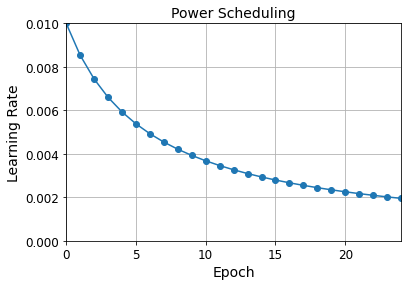

In [84]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [85]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [86]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [87]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [88]:
#los callbacks permiten realizar operaciones durante procesos sobre batch y epochs
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn) 
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8162 - accuracy: 0.7621 - val_loss: 0.8529 - val_accuracy: 0.6948
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7042 - accuracy: 0.7897 - val_loss: 0.5837 - val_accuracy: 0.8206
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6000 - accuracy: 0.8172 - val_loss: 0.6931 - val_accuracy: 0.7914
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5169 - accuracy: 0.8369 - val_loss: 0.5527 - val_accuracy: 0.8420
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5124 - accuracy: 0.8421 - val_loss: 0.4885 - val_accuracy: 0.8512
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4446 - accuracy: 0.8578 - val_loss: 0.4401 - val_accuracy: 0.8604
Epoch 7/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4134 - accuracy: 0.8684 - val_loss: 0.4757 - val_accuracy:

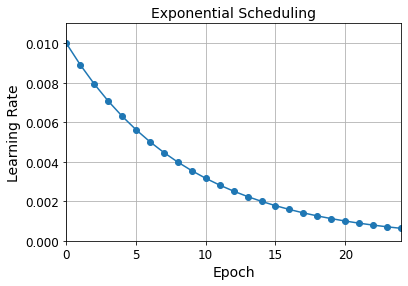

In [89]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [90]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [91]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__() #herencia de clase
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/25
1719/1719 [==============================] - 10s 5ms/step - loss: 0.8022 - accuracy: 0.7697 - val_loss: 0.7336 - val_accuracy: 0.7798
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6870 - accuracy: 0.7919 - val_loss: 0.5695 - val_accuracy: 0.8312
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5598 - accuracy: 0.8226 - val_loss: 0.5991 - val_accuracy: 0.8152
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5254 - accuracy: 0.8354 - val_loss: 0.4565 - val_accuracy: 0.8556
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4798 - accuracy: 0.8491 - val_loss: 0.4868 - val_accuracy: 0.8590
Epoch 6/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4258 - accuracy: 0.8644 - val_loss: 0.4669 - val_accuracy: 0.8604
Epoch 7/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3986 - accuracy: 0.8722 - val_loss: 0.4784 - val_accuracy

In [92]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

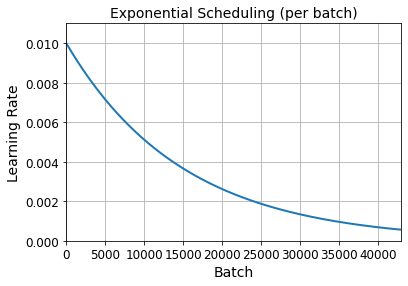

In [93]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [94]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [95]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [96]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8238 - accuracy: 0.7632 - val_loss: 0.8086 - val_accuracy: 0.7764
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.9256 - accuracy: 0.7305 - val_loss: 0.6903 - val_accuracy: 0.7978
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.9588 - accuracy: 0.7213 - val_loss: 1.6671 - val_accuracy: 0.5114
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8126 - accuracy: 0.7596 - val_loss: 0.8462 - val_accuracy: 0.7898
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7794 - accuracy: 0.7846 - val_loss: 0.7873 - val_accuracy: 0.7834
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4985 - accuracy: 0.8505 - val_loss: 0.5573 - val_accuracy: 0.8526
Epoch 7/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4661 - accuracy: 0.8571 - val_loss: 0.5268 - val_accuracy:

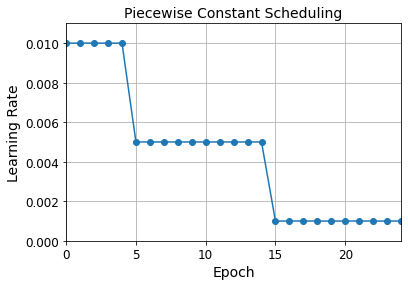

In [97]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [98]:
tf.random.set_seed(42)
np.random.seed(42)

In [99]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5914 - accuracy: 0.8062 - val_loss: 0.4885 - val_accuracy: 0.8460
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5002 - accuracy: 0.8395 - val_loss: 0.5856 - val_accuracy: 0.8326
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5046 - accuracy: 0.8447 - val_loss: 0.5190 - val_accuracy: 0.8582
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5199 - accuracy: 0.8455 - val_loss: 0.4768 - val_accuracy: 0.8506
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5258 - accuracy: 0.8476 - val_loss: 0.5450 - val_accuracy: 0.8398
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5024 - accuracy: 0.8549 - val_loss: 0.6029 - val_accuracy: 0.8572
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5205 - accuracy: 0.8545 - val_loss: 0.5258 - val_accuracy:

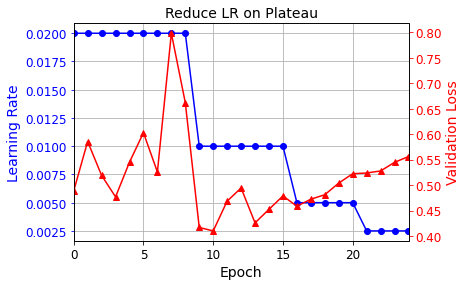

In [100]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [101]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4894 - accuracy: 0.8276 - val_loss: 0.4095 - val_accuracy: 0.8606
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3819 - accuracy: 0.8651 - val_loss: 0.3741 - val_accuracy: 0.8686
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3487 - accuracy: 0.8766 - val_loss: 0.3732 - val_accuracy: 0.8682
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3265 - accuracy: 0.8835 - val_loss: 0.3493 - val_accuracy: 0.8800
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3105 - accuracy: 0.8895 - val_loss: 0.3430 - val_accuracy: 0.8794
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2959 - accuracy: 0.8951 - val_loss: 0.3412 - val_accuracy: 0.8822
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2854 - accuracy: 0.8988 - val_loss: 0.3352 - val_accuracy:

Para scheduling constantes:

In [102]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### [1Cycle scheduling](https://sgugger.github.io/the-1cycle-policy.html)

In [103]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [104]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


430/430 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.3893


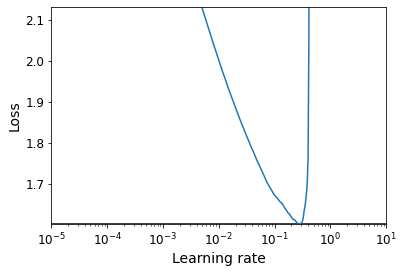

In [105]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [106]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [107]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 4ms/step - loss: 0.6572 - accuracy: 0.7738 - val_loss: 0.4871 - val_accuracy: 0.8334
Epoch 2/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4581 - accuracy: 0.8395 - val_loss: 0.4275 - val_accuracy: 0.8524
Epoch 3/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4121 - accuracy: 0.8545 - val_loss: 0.4115 - val_accuracy: 0.8578
Epoch 4/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3837 - accuracy: 0.8641 - val_loss: 0.3869 - val_accuracy: 0.8684
Epoch 5/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3639 - accuracy: 0.8719 - val_loss: 0.3763 - val_accuracy: 0.8682
Epoch 6/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3456 - accuracy: 0.8773 - val_loss: 0.3744 - val_accuracy: 0.8710
Epoch 7/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3329 - accuracy: 0.8811 - val_loss: 0.3632 - val_accuracy: 0.8708
Epoch 

# Regulizar para evitar sobreajuste en Deep Learning

## $\ell_1$ and $\ell_2$ regularization

* Agrega al costo en backpropagation la norma l1 ($\|w\|_1$) y/o l2 ($\|w\|_2$) de la respectiva capa

In [108]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [109]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 5ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.7197 - accuracy: 0.8274 - val_loss: 0.6850 - val_accuracy: 0.8376


In [110]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 5ms/step - loss: 1.6313 - accuracy: 0.8113 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.7187 - accuracy: 0.8273 - val_loss: 0.6826 - val_accuracy: 0.8382


## Dropout

* Apaga aleatoriamente neuronas en la respectiva capa.

In [111]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5838 - accuracy: 0.7998 - val_loss: 0.3730 - val_accuracy: 0.8642
Epoch 2/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4210 - accuracy: 0.8442 - val_loss: 0.3422 - val_accuracy: 0.8722


## Alpha Dropout

* Dropout manteniendo la media y varianza de las entradas de la capa.
* Mantiene el concepto de auto-normalización (self-normalizing)

In [112]:
tf.random.set_seed(42)
np.random.seed(42)

In [113]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6641 - accuracy: 0.7593 - val_loss: 0.5779 - val_accuracy: 0.8440
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5567 - accuracy: 0.7947 - val_loss: 0.5214 - val_accuracy: 0.8516
Epoch 3/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5209 - accuracy: 0.8083 - val_loss: 0.4887 - val_accuracy: 0.8598
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5085 - accuracy: 0.8119 - val_loss: 0.4914 - val_accuracy: 0.8586
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4952 - accuracy: 0.8184 - val_loss: 0.4305 - val_accuracy: 0.8690
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4826 - accuracy: 0.8212 - val_loss: 0.4617 - val_accuracy: 0.8628
Epoch 7/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4722 - accuracy: 0.8248 - val_loss: 0.4662 - val_accuracy:

In [114]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4826 - accuracy: 0.8593


[0.48257920145988464, 0.8593000173568726]

In [115]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 4s 2ms/step - loss: 0.3598 - accuracy: 0.8806


[0.35979604721069336, 0.8805636167526245]

In [116]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 5s 3ms/step - loss: 0.4217 - accuracy: 0.8432


## MC Dropout

* Estimación de salida después de entrenar red por simulación de Monte-Carlo (varias realizaciones del  experimento), en donde la aleatoriedad es controlada por el Dropout.

* Cada evaluación de una nueva muestra puede variar su  salida por el Dropout.

* Se generan varias corridas para predecir la salida de un punto con la red entrenada, y la predicción final sera el promedio muestral de las predicciones sobre el experimento de Monte-Carlo.

* MC Dropot se relaciona con inferencia Bayesiana aproximada y provee una alternativa para cuantificar la incertidumbre del modelo en DL.

In [117]:
tf.random.set_seed(42)
np.random.seed(42)

In [118]:
model(X_test_scaled,training=True).shape

TensorShape([10000, 10])

In [119]:
y_probas = np.stack([model(X_test_scaled, training=True) # se activa training en True para que el Dropout se aplique
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)
y_probas.shape

(100, 10000, 10)

In [120]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98]],
      dtype=float32)

In [121]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.96, 0.  , 0.03]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.2 , 0.  , 0.79]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.76, 0.  , 0.24]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.72, 0.  , 0.27]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.41, 0.  , 0.56]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.53, 0.  , 0.42]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.08, 0.  , 0.8 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.11, 0.  , 0.88]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.43, 0.  , 0.37]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.85]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.22, 0.  , 0.67]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.3 , 0.  , 0

In [122]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.24, 0.  , 0.71]],
      dtype=float32)

In [123]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.25, 0.  , 0.29]],
      dtype=float32)

In [124]:
y_pred = np.argmax(y_proba, axis=1)

In [125]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8668

In [126]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [127]:
tf.random.set_seed(42)
np.random.seed(42)

In [128]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [129]:
mc_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_262 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 10)              

In [130]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [131]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [132]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.25, 0.  , 0.64]],
      dtype=float32)

## Max norm

* Se restringe la capa a que su norma no supere un determinado valor durante el backpropagation.

In [133]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [134]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4755 - accuracy: 0.8329 - val_loss: 0.3790 - val_accuracy: 0.8636
Epoch 2/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3550 - accuracy: 0.8714 - val_loss: 0.3818 - val_accuracy: 0.8656
